# Libraries

In [1]:
# Main
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Other
import os
from joblib import dump

# Setup

In [2]:
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
path = "../CSV Files"

train = pd.read_csv(path+"/train.csv", index_col="id")
test = pd.read_csv(path+"/test.csv",  index_col="id")

# Functions

In [5]:
def wrangle(X):
    # make a copy
    X = X.copy()
    
    # encode "t" and "f" as 1's and 0's
    X['host_has_profile_pic'][X['host_has_profile_pic']=='t'] = 1
    X['host_has_profile_pic'][X['host_has_profile_pic']=='f'] = 0
    
    X['host_identity_verified'][X['host_identity_verified']=='t'] = 1
    X['host_identity_verified'][X['host_identity_verified']=='f'] = 0
    
    X['host_has_profile_pic'] = X['host_has_profile_pic'].astype(float)
    X['host_identity_verified'] = X['host_identity_verified'].astype(float)
    
    X['instant_bookable'][X['instant_bookable']=='t'] = 1
    X['instant_bookable'][X['instant_bookable']=='f'] = 0
    
    # Group some of the many property types together
    X['property_type'][X['property_type'].isin(['Boat','Tent','Castle','Yurt', 'Hut', 'Treehouse',
                                                'Chalet','Earth House','Tipi','Cave',
                                                'Train','Parking Space','Island','Casa particular',
                                                'Lighthouse', 'Vacation home', 'Serviced apartment'])] = 'Other'

    # columns with unusable variance
    unusable_variance = ['zipcode']

    # columns with high percentage of missing values
    high_nans = ['first_review','host_response_rate','last_review',
                 'review_scores_rating','thumbnail_url']

    # categorical variables with high cardinality
    # 'neighborhood' has 620 and 'thumbnail_url' has many thousands
    high_card = ['neighbourhood','thumbnail_url','name','amenities',
                 'description', 'host_since']

    # Get the price and drop the log of price
    X['price'] = np.exp(X['log_price'])
    X = X.drop(['log_price'] + unusable_variance + high_nans + high_card, axis=1)

    return X

In [6]:
def prepare_inputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # encode
        train_enc = le.fit_transform(X_train.iloc[:, i].values)
        test_enc = le.fit_transform(X_test.iloc[:, i].values)
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

In [7]:
def scale_inputs(X_train, X_test):
    ss = StandardScaler()
    ss.fit_transform(X_train, X_test)
    return X_train, X_test

In [8]:
def model_creation():
    lr = .01
    opt = Adam(lr)
    input_shape = 16
    prob = .20
    l2 = 0.01

    hl_nodes = 64
    hl_nodes_2 = 64
    hl_nodes_3 = 64
    ol_nodes = 1
    
    model = Sequential([
    Dense(hl_nodes, 
          activation='relu', 
          input_dim=input_shape,
          kernel_regularizer=regularizers.l2(l2)),
    
    Dropout(prob),
        
    Dense(hl_nodes_2, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
        
    Dense(hl_nodes_3, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
        
    Dense(ol_nodes, 
          activation='linear')
])
    
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

# EDA

In [9]:
print(train.shape)
train.head()

(74111, 28)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 

In [11]:
train = wrangle(train)

In [12]:
train.head()

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,bedrooms,beds,price
id,,,,,,,,,,,,,,,,,
6901257,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,1.0,1.0,0,40.696524,-73.991617,2,1.0,1.0,150.0
6304928,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,1.0,0.0,1,40.766115,-73.989040,6,3.0,3.0,169.0
7919400,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,1.0,1.0,1,40.808110,-73.943756,10,1.0,3.0,145.0
13418779,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,1.0,1.0,0,37.772004,-122.431619,0,2.0,2.0,750.0
3808709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,1.0,1.0,1,38.925627,-77.034596,4,0.0,1.0,115.0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           74111 non-null  object 
 1   room_type               74111 non-null  object 
 2   accommodates            74111 non-null  int64  
 3   bathrooms               73911 non-null  float64
 4   bed_type                74111 non-null  object 
 5   cancellation_policy     74111 non-null  object 
 6   cleaning_fee            74111 non-null  bool   
 7   city                    74111 non-null  object 
 8   host_has_profile_pic    73923 non-null  float64
 9   host_identity_verified  73923 non-null  float64
 10  instant_bookable        74111 non-null  object 
 11  latitude                74111 non-null  float64
 12  longitude               74111 non-null  float64
 13  number_of_reviews       74111 non-null  int64  
 14  bedrooms                74020 

# Split

In [14]:
target = 'price'
X = train.drop(target, axis=1)
y = train[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.20,
                                                    random_state=0)

In [16]:
print(X_train.shape)
print(X_test.shape)

(59288, 16)
(14823, 16)


# Baseline

In [17]:
baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print('Baseline MAE:', round(baseline,2))

Baseline MAE: 97.59


# Pre-fitting

In [18]:
X_train, X_test = prepare_inputs(X_train, X_test)

In [19]:
X_train, X_test = scale_inputs(X_train, X_test)

In [20]:
X_train = [list(X_train[i]) for i in range(len(X_train))]
X_train = np.asarray(X_train).T

X_test = [list(X_test[i]) for i in range(len(X_test))]
X_test = np.asarray(X_test).T

In [21]:
print(X_train.shape)
print(X_test.shape)

(59288, 16)
(14823, 16)


# Model

In [22]:
model = KerasRegressor(model_creation, verbose=1)

In [23]:
!rm -rf ./logs/

In [24]:
%load_ext tensorboard

logdir = os.path.join("logs", "EarlyStopping")

board_callback = TensorBoard(logdir, histogram_freq=1)

stop = EarlyStopping(monitor="val_loss",
                     min_delta=0,
                     patience=3)

checkpoint = ModelCheckpoint("weights_best.h5", 
                             save_weights_only=True)

In [25]:
result = model.fit(X_train, y_train,
                   epochs=16, batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[board_callback, stop, checkpoint])

Epoch 1/16
   1/1853 [..............................] - ETA: 0s - loss: 18454708.0000 - mean_absolute_error: 3234.1216WARNING:tensorflow:From c:\users\lester\.virtualenvs\front_end-otay-o1y\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1853/1853 [==============================] - 2s 810us/step - loss: 82467.6953 - mean_absolute_error: 126.5007 - val_loss: 47838.8672 - val_mean_absolute_error: 137.1629
Epoch 2/16
1853/1853 [==============================] - 1s 700us/step - loss: 33693.7031 - mean_absolute_error: 104.1737 - val_loss: 44947.4375 - val_mean_absolute_error: 126.8306
Epoch 3/16
1853/1853 [==============================] - 1s 709us/step - loss: 31995.5586 - mean_absolute_error: 99.1983 - val_loss: 28369.4473 - val_mean_absolute_error: 96.4331
Epoch 4/16
1853/1853 [============================

In [26]:
result.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

In [27]:
result.model.evaluate(X_train, y_train)

1853/1853 [==============================] - 1s 336us/step - loss: 28268.8125 - mean_absolute_error: 98.9842


[28268.8125, 98.98421478271484]

In [28]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23624), started 3:18:35 ago. (Use '!kill 23624' to kill it.)

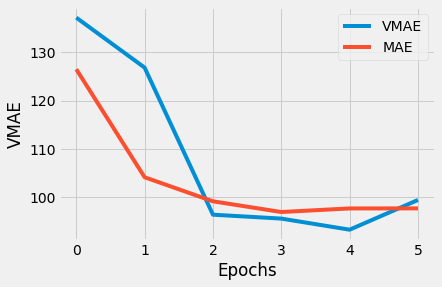

In [29]:
df = pd.DataFrame.from_records(result.history)
df['epoch'] = [i for i in range(df.shape[0])]

plt.plot(df['epoch'], df['val_mean_absolute_error'], label="VMAE")
plt.plot(df['epoch'], df['mean_absolute_error'], label="MAE")
plt.xticks(df['epoch'])
plt.ylabel("VMAE")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [30]:
result.model.save('keras_model.h5')

# Tune

In [31]:
params = {
    'batch_size': [32,64,512],
    'epochs': [32,64,512]
}

grid = GridSearchCV(model,
                    params,
                    cv=2,
                    n_jobs=-1,
                    verbose=1)

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  2.9min remaining:   50.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.4min finished


Epoch 1/512
116/116 [==============================] - 0s 1ms/step - loss: 695540.2500 - mean_absolute_error: 283.4199
Epoch 2/512
116/116 [==============================] - 0s 1ms/step - loss: 35901.1992 - mean_absolute_error: 110.4006
Epoch 3/512
116/116 [==============================] - 0s 1ms/step - loss: 35439.8438 - mean_absolute_error: 109.4078
Epoch 4/512
116/116 [==============================] - 0s 1ms/step - loss: 35082.6055 - mean_absolute_error: 108.3302
Epoch 5/512
116/116 [==============================] - 0s 2ms/step - loss: 34826.4766 - mean_absolute_error: 107.6994
Epoch 6/512
116/116 [==============================] - 0s 1ms/step - loss: 34717.8047 - mean_absolute_error: 107.1324
Epoch 7/512
116/116 [==============================] - 0s 1ms/step - loss: 34287.2305 - mean_absolute_error: 106.2337
Epoch 8/512
116/116 [==============================] - 0s 1ms/step - loss: 33961.7188 - mean_absolute_error: 105.4371
Epoch 9/512
116/116 [==============================] - 

116/116 [==============================] - 0s 1ms/step - loss: 22001.3730 - mean_absolute_error: 81.3736
Epoch 70/512
116/116 [==============================] - 0s 1ms/step - loss: 21408.9805 - mean_absolute_error: 79.6606
Epoch 71/512
116/116 [==============================] - 0s 1ms/step - loss: 22191.6543 - mean_absolute_error: 81.0214
Epoch 72/512
116/116 [==============================] - 0s 1ms/step - loss: 23003.5625 - mean_absolute_error: 83.9858
Epoch 73/512
116/116 [==============================] - 0s 1ms/step - loss: 22217.2070 - mean_absolute_error: 80.8717
Epoch 74/512
116/116 [==============================] - 0s 1ms/step - loss: 21433.4277 - mean_absolute_error: 80.1046
Epoch 75/512
116/116 [==============================] - 0s 1ms/step - loss: 22159.2461 - mean_absolute_error: 81.3985
Epoch 76/512
116/116 [==============================] - 0s 1ms/step - loss: 21998.8770 - mean_absolute_error: 80.8739
Epoch 77/512
116/116 [==============================] - 0s 1ms/step -

116/116 [==============================] - 0s 1ms/step - loss: 21868.4180 - mean_absolute_error: 82.2962
Epoch 138/512
116/116 [==============================] - 0s 1ms/step - loss: 22895.0703 - mean_absolute_error: 85.0601
Epoch 139/512
116/116 [==============================] - 0s 1ms/step - loss: 21921.5820 - mean_absolute_error: 82.4959
Epoch 140/512
116/116 [==============================] - 0s 1ms/step - loss: 21612.8906 - mean_absolute_error: 81.9684
Epoch 141/512
116/116 [==============================] - 0s 1ms/step - loss: 21679.2988 - mean_absolute_error: 81.5053
Epoch 142/512
116/116 [==============================] - 0s 1ms/step - loss: 22933.7422 - mean_absolute_error: 85.0343
Epoch 143/512
116/116 [==============================] - 0s 1ms/step - loss: 28348.2363 - mean_absolute_error: 96.7729
Epoch 144/512
116/116 [==============================] - 0s 1ms/step - loss: 28274.3906 - mean_absolute_error: 96.9615
Epoch 145/512
116/116 [==============================] - 0s 1m

116/116 [==============================] - 0s 1ms/step - loss: 21628.1094 - mean_absolute_error: 81.5191
Epoch 206/512
116/116 [==============================] - 0s 1ms/step - loss: 23034.7949 - mean_absolute_error: 85.9906
Epoch 207/512
116/116 [==============================] - 0s 1ms/step - loss: 22457.6641 - mean_absolute_error: 84.1645
Epoch 208/512
116/116 [==============================] - 0s 1ms/step - loss: 22142.8906 - mean_absolute_error: 83.0321
Epoch 209/512
116/116 [==============================] - 0s 1ms/step - loss: 21839.9844 - mean_absolute_error: 81.9219
Epoch 210/512
116/116 [==============================] - 0s 1ms/step - loss: 22518.9785 - mean_absolute_error: 84.0701
Epoch 211/512
116/116 [==============================] - 0s 2ms/step - loss: 21861.5605 - mean_absolute_error: 81.9277
Epoch 212/512
116/116 [==============================] - 0s 2ms/step - loss: 22700.7637 - mean_absolute_error: 84.6146
Epoch 213/512
116/116 [==============================] - 0s 1m

116/116 [==============================] - 0s 1ms/step - loss: 28512.2598 - mean_absolute_error: 97.2809
Epoch 274/512
116/116 [==============================] - 0s 1ms/step - loss: 28482.4805 - mean_absolute_error: 97.0010
Epoch 275/512
116/116 [==============================] - 0s 2ms/step - loss: 28449.2500 - mean_absolute_error: 97.4344
Epoch 276/512
116/116 [==============================] - 0s 1ms/step - loss: 28448.9668 - mean_absolute_error: 97.2415
Epoch 277/512
116/116 [==============================] - 0s 1ms/step - loss: 28442.8320 - mean_absolute_error: 96.9706
Epoch 278/512
116/116 [==============================] - 0s 1ms/step - loss: 28468.2324 - mean_absolute_error: 97.4077
Epoch 279/512
116/116 [==============================] - 0s 1ms/step - loss: 28462.5684 - mean_absolute_error: 97.2806
Epoch 280/512
116/116 [==============================] - 0s 1ms/step - loss: 28441.7129 - mean_absolute_error: 97.2740
Epoch 281/512
116/116 [==============================] - 0s 1m

Epoch 342/512
116/116 [==============================] - 0s 1ms/step - loss: 28320.2656 - mean_absolute_error: 97.3912
Epoch 343/512
116/116 [==============================] - 0s 1ms/step - loss: 28313.9102 - mean_absolute_error: 97.3179
Epoch 344/512
116/116 [==============================] - 0s 1ms/step - loss: 28313.8496 - mean_absolute_error: 97.2868
Epoch 345/512
116/116 [==============================] - 0s 1ms/step - loss: 28319.7500 - mean_absolute_error: 97.5042
Epoch 346/512
116/116 [==============================] - 0s 1ms/step - loss: 28315.8789 - mean_absolute_error: 97.4796
Epoch 347/512
116/116 [==============================] - 0s 1ms/step - loss: 28272.5820 - mean_absolute_error: 97.2902
Epoch 348/512
116/116 [==============================] - 0s 1ms/step - loss: 28291.8438 - mean_absolute_error: 97.3080
Epoch 349/512
116/116 [==============================] - 0s 1ms/step - loss: 28285.3359 - mean_absolute_error: 97.5576
Epoch 350/512
116/116 [=========================

116/116 [==============================] - 0s 2ms/step - loss: 28105.9980 - mean_absolute_error: 96.8081
Epoch 411/512
116/116 [==============================] - 0s 2ms/step - loss: 27994.4941 - mean_absolute_error: 96.2205
Epoch 412/512
116/116 [==============================] - 0s 2ms/step - loss: 28093.2480 - mean_absolute_error: 96.5576
Epoch 413/512
116/116 [==============================] - 0s 1ms/step - loss: 28070.9883 - mean_absolute_error: 96.6981
Epoch 414/512
116/116 [==============================] - 0s 2ms/step - loss: 28049.3555 - mean_absolute_error: 96.7330
Epoch 415/512
116/116 [==============================] - 0s 2ms/step - loss: 27949.8809 - mean_absolute_error: 96.4046
Epoch 416/512
116/116 [==============================] - 0s 2ms/step - loss: 27966.3652 - mean_absolute_error: 96.1718
Epoch 417/512
116/116 [==============================] - 0s 1ms/step - loss: 27927.2734 - mean_absolute_error: 96.2597
Epoch 418/512
116/116 [==============================] - 0s 1m

116/116 [==============================] - 0s 1ms/step - loss: 28011.6758 - mean_absolute_error: 96.6199
Epoch 479/512
116/116 [==============================] - 0s 1ms/step - loss: 28081.7090 - mean_absolute_error: 96.6798
Epoch 480/512
116/116 [==============================] - 0s 1ms/step - loss: 27999.0410 - mean_absolute_error: 96.7736
Epoch 481/512
116/116 [==============================] - 0s 1ms/step - loss: 28044.7988 - mean_absolute_error: 96.7274
Epoch 482/512
116/116 [==============================] - 0s 1ms/step - loss: 27989.3242 - mean_absolute_error: 96.1426
Epoch 483/512
116/116 [==============================] - 0s 1ms/step - loss: 27942.6133 - mean_absolute_error: 96.0209
Epoch 484/512
116/116 [==============================] - 0s 1ms/step - loss: 27955.2500 - mean_absolute_error: 96.5259
Epoch 485/512
116/116 [==============================] - 0s 1ms/step - loss: 27913.1328 - mean_absolute_error: 96.0989
Epoch 486/512
116/116 [==============================] - 0s 1m

In [32]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print(f"Mean test score: {grid_result.cv_results_['mean_test_score']}")

Best: -20615.3955078125 using {'batch_size': 512, 'epochs': 512}
Mean test score: [-28282.19335938 -28272.88867188 -28251.94824219 -28294.20605469
 -28259.28613281 -28258.03222656 -31049.15722656 -26234.53417969
 -20615.39550781]
